<a href="https://colab.research.google.com/github/NRafif/Machine-Learning/blob/main/Model_With_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIBRARY

In [1]:
from google.colab import files    # Untuk upload files
import zipfile                    # Untuk unzip file
import os                         # Untuk interaksi dengan os
import matplotlib.pyplot as plt   # Untuk visualisasi data
import matplotlib.image as mpimg  # Membaca dan memanipulasi gambar
from google.colab import drive    # Untuk mengakses google drive
import tensorflow as tf           # Library utama untuk Machine learning
import numpy as np                # Library untuk komputasi numerik
from PIL import Image
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2

In [2]:
batch_size = 64
img_height = 224
img_width = 224

# PERSIAPAN DATASET


Mengambil dataset dari kaggle

In [3]:
!pip install -q Kaggle

In [4]:
# uploaded = files.upload()

In [5]:
!mkdir -p ~/.kaggle                #membuat folder .kaggle di root
!mv kaggle.json ~/.kaggle/         #memindahkan file kaggle.json ke folder ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json   #merubah permission file kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [6]:
!kaggle datasets download -d nofalrafif/cat-skin-disease

Dataset URL: https://www.kaggle.com/datasets/nofalrafif/cat-skin-disease
License(s): unknown
cat-skin-disease.zip: Skipping, found more recently modified local copy (use --force to force download)


Load Dataset


In [7]:
# Extract zipfile
! unzip "/content/cat-skin-disease.zip" -d.

Archive:  /content/cat-skin-disease.zip
replace ./dataset/CAT SKIN DISEASE/Health/-XB1nkYr8x8_jpg.rf.488035c88ae23b7e516202935dcd5cb4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./dataset/CAT SKIN DISEASE/Health/-XB1nkYr8x8_jpg.rf.488035c88ae23b7e516202935dcd5cb4.jpg  
  inflating: ./dataset/CAT SKIN DISEASE/Health/-e0QDP4sFro_jpg.rf.79e7e30bdb48ec52d1174ef79c91b9ff.jpg  
  inflating: ./dataset/CAT SKIN DISEASE/Health/-q6SDw4zo90_jpg.rf.a50638511d43faa8b2d1b745421a5b1e.jpg  
  inflating: ./dataset/CAT SKIN DISEASE/Health/0001-YE-pDvdMSPU_jpg.rf.8e5c96d008a7de691af15f13c9c91741.jpg  
  inflating: ./dataset/CAT SKIN DISEASE/Health/0002-Kpmi7OMZGco_jpg.rf.25bb175383508dbc050f3a7a008cb384.jpg  
  inflating: ./dataset/CAT SKIN DISEASE/Health/0002-Kpmi7OMZGco_jpg.rf.792af3151465d9328ca952010a6cb8d4.jpg  
  inflating: ./dataset/CAT SKIN DISEASE/Health/0002-Kpmi7OMZGco_jpg.rf.ce000713629e2557290f208d0f713cbf.jpg  
  inflating: ./dataset/CAT SKIN DISEASE/Health/0003-Zx043ICtTtE_jp

Menentukan class

In [11]:
cat_disease = "/content/dataset/CAT SKIN DISEASE"
cat_disease_classes = os.listdir(cat_disease)

In [12]:
print("Cat Skin Disease Class :")
for class_name in cat_disease_classes:
  if os.path.isdir(os.path.join(cat_disease, class_name)):
    print(class_name)

Cat Skin Disease Class :
Ringworm
Lepra
Scabies
Health


Preview Gambar


Ringworm
Total Image :  572
Resolusi Gambar :  (640, 640, 3)


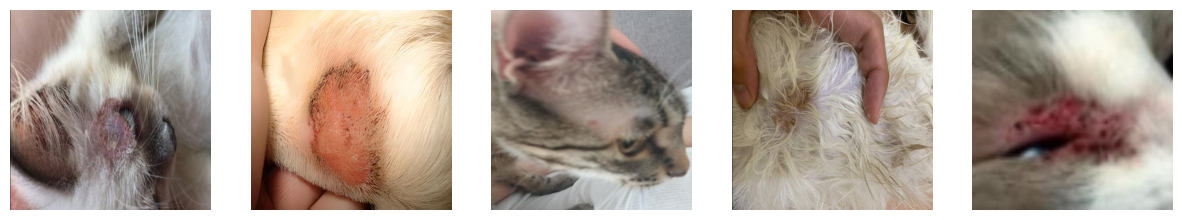


Lepra
Total Image :  437
Resolusi Gambar :  (484, 650, 3)


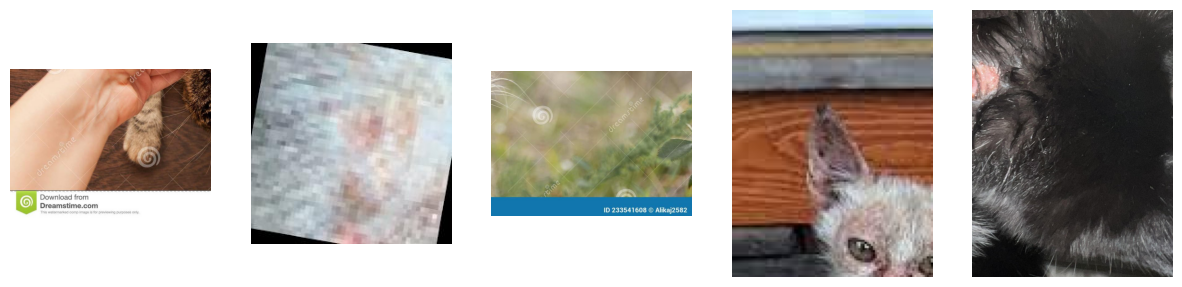


Scabies
Total Image :  509
Resolusi Gambar :  (640, 640, 3)


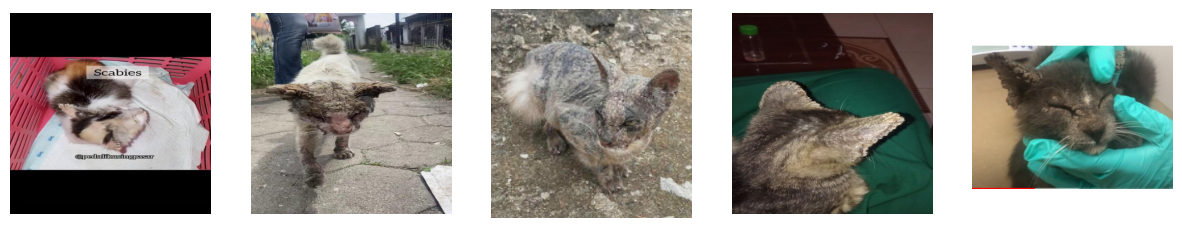


Health
Total Image :  503
Resolusi Gambar :  (640, 640, 3)


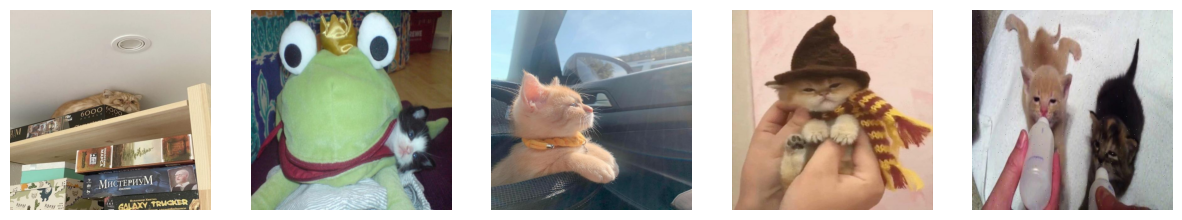

In [13]:
for item in cat_disease_classes:
    print("")
    print(item)
    class_dir = os.path.join(cat_disease, item)
    class_images = [img for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

    # Menghitung total image di setiap kelas
    num_images = len(class_images)
    print("Total Image : ", num_images)

    # Menghitung resolusi pada gambar pertama
    img_path = os.path.join(class_dir, class_images[0])
    img = mpimg.imread(img_path)
    image_shape = img.shape
    print("Resolusi Gambar : ", image_shape)

    # Menampilkan beberapa gambar
    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(class_images))):  # Tampilkan maksimum 5 gambar atau sesuai jumlah yang tersedia
        sp = plt.subplot(1, 5, i + 1)
        img = mpimg.imread(os.path.join(class_dir, class_images[i]))
        plt.axis('off')
        plt.imshow(img)
    plt.show()


# PREPOCESING DATA


Split data

In [14]:
def train_val_Dataset():
  training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
      cat_disease,
      image_size=(img_height, img_width),
      color_mode='rgb',
      batch_size= batch_size,
      label_mode='categorical',
      validation_split=0.2,
      subset='both',
      shuffle=True,
      seed=42
  )

  return training_dataset, validation_dataset

In [15]:
# Membuat dataset
training_dataset, validation_dataset = train_val_Dataset()

Found 2021 files belonging to 4 classes.
Using 1617 files for training.
Using 404 files for validation.


In [16]:
# Melihat batch pertama dari image dan labels
for image_batch, labels_batch in training_dataset.take(1):
  example_batch = image_batch
  labels_batch = labels_batch

  print(f"maximum pixel value of images : {np.max(example_batch)}.\n")
  print(f"Image batch shape: {image_batch.shape}")
  print(f"Labels batch shape: {labels_batch.shape}")

maximum pixel value of images : 255.0.

Image batch shape: (64, 224, 224, 3)
Labels batch shape: (64, 4)


Augmentation

In [17]:
def create_augmentation_model():
    augmentation_model = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("vertical"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        tf.keras.layers.RandomContrast(0.2),
    ])
    return augmentation_model

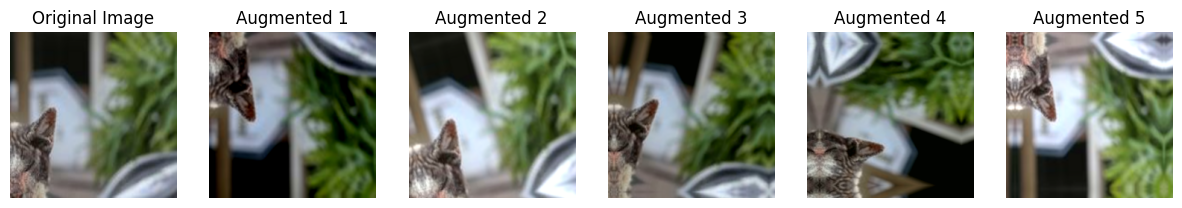

In [18]:
# Load your model for augmentation
data_augmentor = create_augmentation_model()

# Take a sample image
sample_image = tf.keras.utils.array_to_img(example_batch[0])

images = [sample_image]

# Apply random augmentation 5 times
for _ in range(5):
	image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 6, figsize=(15, 5))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3','Augmented 4','Augmented 5']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

# MODELING

In [19]:
def create_transfer_learning_model():
    # Load MobileNetV2 without the top layer
    base_model = MobileNetV2(
        input_shape=(img_height, img_width, 3),
        include_top=False,
        weights="imagenet"
    )

    # Freeze the base model
    base_model.trainable = False

    # Augmentation layers
    augmentation_layers = create_augmentation_model()

    # Add custom layers
    # The Input layer is added to specify the input shape explicitly
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
        augmentation_layers,
        tf.keras.layers.Rescaling(1./255),
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(4, activation="softmax"),
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [21]:
create_transfer_learning_model().summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │       2,007,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,276,004 (16.31 MB)

 Trainable params: 2,018,020 (7.70 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Buat fungsi callback

In [25]:
class early_stopping_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if logs.get('accuracy')>=0.8 and logs.get('val_accuracy')>=0.7:
      print("\nReached 80% train accuracy and 70% val accuracy so cancelling training!")
      self.model.stop_training = True

Mulai train model

In [ ]:
history = create_transfer_learning_model().fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=100,
    verbose=2,
    callbacks=[early_stopping_callback()]
)

Epoch 1/100
26/26 - 12s - 448ms/step - accuracy: 0.3352 - loss: 1.5235 - val_accuracy: 0.4950 - val_loss: 1.2187
Epoch 2/100
26/26 - 6s - 214ms/step - accuracy: 0.4069 - loss: 1.2959 - val_accuracy: 0.6337 - val_loss: 0.9783
Epoch 3/100
26/26 - 4s - 143ms/step - accuracy: 0.4471 - loss: 1.2306 - val_accuracy: 0.5644 - val_loss: 1.0693
Epoch 4/100
26/26 - 4s - 143ms/step - accuracy: 0.4954 - loss: 1.1437 - val_accuracy: 0.6436 - val_loss: 0.9361
Epoch 5/100
26/26 - 7s - 268ms/step - accuracy: 0.5022 - loss: 1.1313 - val_accuracy: 0.6733 - val_loss: 0.8606
Epoch 6/100
26/26 - 9s - 339ms/step - accuracy: 0.5232 - loss: 1.0695 - val_accuracy: 0.6782 - val_loss: 0.8078
Epoch 7/100
26/26 - 5s - 177ms/step - accuracy: 0.5331 - loss: 1.0472 - val_accuracy: 0.6658 - val_loss: 0.8257
Epoch 8/100
26/26 - 5s - 182ms/step - accuracy: 0.5510 - loss: 1.0457 - val_accuracy: 0.6807 - val_loss: 0.8084
Epoch 9/100
26/26 - 6s - 219ms/step - accuracy: 0.5405 - loss: 1.0476 - val_accuracy: 0.6708 - val_loss

# Hasil Model

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Training and Validation Accuracy and Loss')

# Define data and labels for each subplot
data_labels = [
    (acc, val_acc, 'Accuracy'),
    (loss, val_loss, 'Loss')
]

# Iterate through subplots and data
for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    axs[i].plot(epochs_range, data[0], 'r', label="Training " + label)
    axs[i].plot(epochs_range, data[1], 'b', label="Validation " + label)
    axs[i].legend()
    axs[i].set_xlabel('epochs')

plt.show()

Model 2

In [ ]:
def predict_image(image_path, model):
    img = Image.open(image_path)
    img = img.resize((img_height, img_width))  # Resize image

    # Convert image to RGB format
    img = img.convert('RGB')  # This line is added to convert the image to RGB

    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Memprediksi kelas yang
    predicted_class_name = cat_disease_classes[predicted_class]

    return predicted_class_name, prediction


# Upload file
uploaded = files.upload()

# Informasi file yang diupload
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Membuat prediksi
image_path = fn # Menggunakan nama file yang diupload
predicted_class_name, prediction = predict_image(image_path, create_transfer_learning_model()) # Gunakan model yang telah dilatih

print(f"Predicted class: {predicted_class_name}")
print(f"Prediction probabilities: {prediction}")

# Display the uploaded image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class_name}")
plt.show()

In [ ]:
def predict_image(image_path, model):
    img = Image.open(image_path)
    img = img.resize((img_height, img_width))  # Resize image

    # Convert image to RGB format
    img = img.convert('RGB')  # This line is added to convert the image to RGB

    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Memprediksi kelas yang
    predicted_class_name = cat_disease_classes[predicted_class]

    return predicted_class_name, prediction


# Upload file
uploaded = files.upload()

# Informasi file yang diupload
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Membuat prediksi
image_path = fn # Menggunakan nama file yang diupload
predicted_class_name, prediction = predict_image(image_path, create_transfer_learning_model()) # Gunakan model yang telah dilatih

print(f"Predicted class: {predicted_class_name}")
print(f"Prediction probabilities: {prediction}")

# Display the uploaded image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class_name}")
plt.show()